# Домашнее задание 

В этом задании мы попрактикуемся в методах снижения размерности и кластеризации данных. 

Мы будем работать с набором данных Samsung Human Activity Recognition. Скачайте данные по ссылке https://archive.ics.uci.edu/ml/machine-learning-databases/00240/. Данные поступают с акселерометров и гироскопов мобильных телефонов Samsung Galaxy S3, также известен вид активности человека с телефоном в кармане – ходил ли он, стоял, лежал, сидел или шел вверх/вниз по лестнице.

Представим, что вид активности нам неизвестнен, и попробуем кластеризовать людей чисто на основе имеющихся признаков.

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-v0_8-dark-palette']) # была такая ошибка, поэтому поменяла 'seaborn-darkgrid' is not a valid package style, path of style file, URL of style file, or library style name (library styles are listed in `style.available`)
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

RANDOM_STATE = 17

In [ ]:
#X_train = np.loadtxt("X_train.txt")
#y_train = np.loadtxt("y_train.txt").astype(int)

#X_test = np.loadtxt("X_test.txt")
#y_test = np.loadtxt("y_test.txt").astype(int)

Для кластеризации нам не нужен вектор ответов. Объедините обучающую и тестовую выборки.

In [66]:
# скачала датасет с Kaggle 
testdata = pd.read_csv('test.csv')
traindata = pd.read_csv('train.csv')

In [67]:
traindata.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",subject,Activity
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,1,STANDING
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,1,STANDING
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,1,STANDING
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,1,STANDING
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,1,STANDING


In [68]:
data = pd.concat([traindata, testdata])

In [69]:
X = data.drop('Activity', axis=1)
y = data['Activity']

In [70]:
np.unique(y)

array(['LAYING', 'SITTING', 'STANDING', 'WALKING', 'WALKING_DOWNSTAIRS',
       'WALKING_UPSTAIRS'], dtype=object)

In [71]:
def numericactivity(y):
    newvalues = {'WALKING': 1, 'WALKING_UPSTAIRS': 2, 'WALKING_DOWNSTAIRS': 3, 'SITTING': 4, 'STANDING': 5, 'LAYING': 6}
    return newvalues.get(y)

y = y.map(numericactivity)

In [72]:
y.sample(10)

1076    4
853     5
5386    1
2139    1
5154    6
1384    5
2868    2
4447    6
5671    2
3410    2
Name: Activity, dtype: int64

Эти метки соответствуют:

1 - ходьбе,
2 - подъему вверх по лестнице,
3 - спуску по лестнице,
4 - сидению,
5 - стоянию,
6 - лежанию

Отмасштабируйте выборку с помощью StandardScaler.

In [73]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Понижаем размерность с помощью PCA, оставляя столько компонент, сколько нужно для того, чтобы объяснить как минимум 90% дисперсии исходных (отмасштабированных) данных. Используйте отмасштабированную выборку и зафиксируйте random_state.

In [74]:
# решила тут погридсерчить
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA())
])

param_grid = {
    'pca__n_components': [0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99] 
}

grid_search = GridSearchCV(pipe, param_grid, cv=5)

grid_search.fit(X_scaled)

# получение оптимального числа n_components
best_n_components = grid_search.best_params_['pca__n_components']

pca = PCA(n_components=best_n_components)
X_pca = pca.fit_transform(X_scaled)

Визуализируйте данные в проекции на первые две главные компоненты.

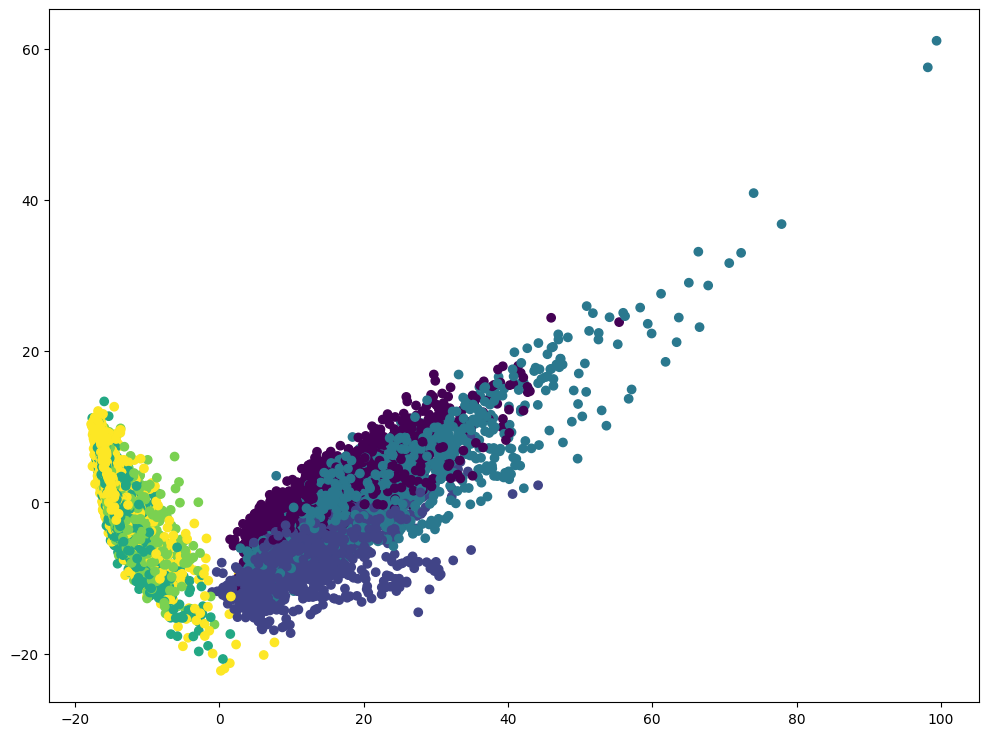

In [12]:
#your code here
plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis')

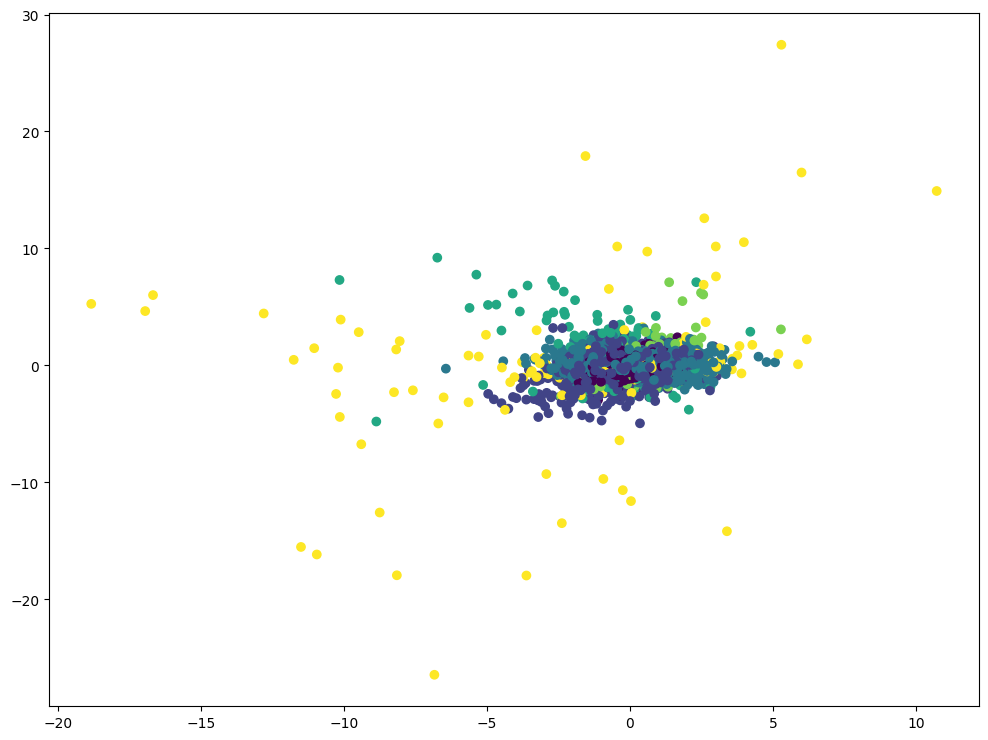

In [13]:
# интересно, как было до
plt.scatter(X_scaled[:,0], X_scaled[:,1], c=y, cmap='viridis')

Сделайте кластеризацию данных методом KMeans, обучив модель на данных со сниженной за счет PCA размерностью. В данном случае нужно искать 6 кластеров (так как у нас 6 классов).

Параметры:

n_clusters = n_classes (число уникальных меток целевого класса)

n_init = 100

random_state = RANDOM_STATE (для воспроизводимости результата)

In [14]:
km = KMeans(n_clusters=6, random_state=RANDOM_STATE, n_init=100)
km.fit(X_pca)

KMeans(n_clusters=6, n_init=100, random_state=17)

Визуализируйте данные в проекции на первые две главные компоненты. Раскрасьте точки в соответствии с полученными метками кластеров.

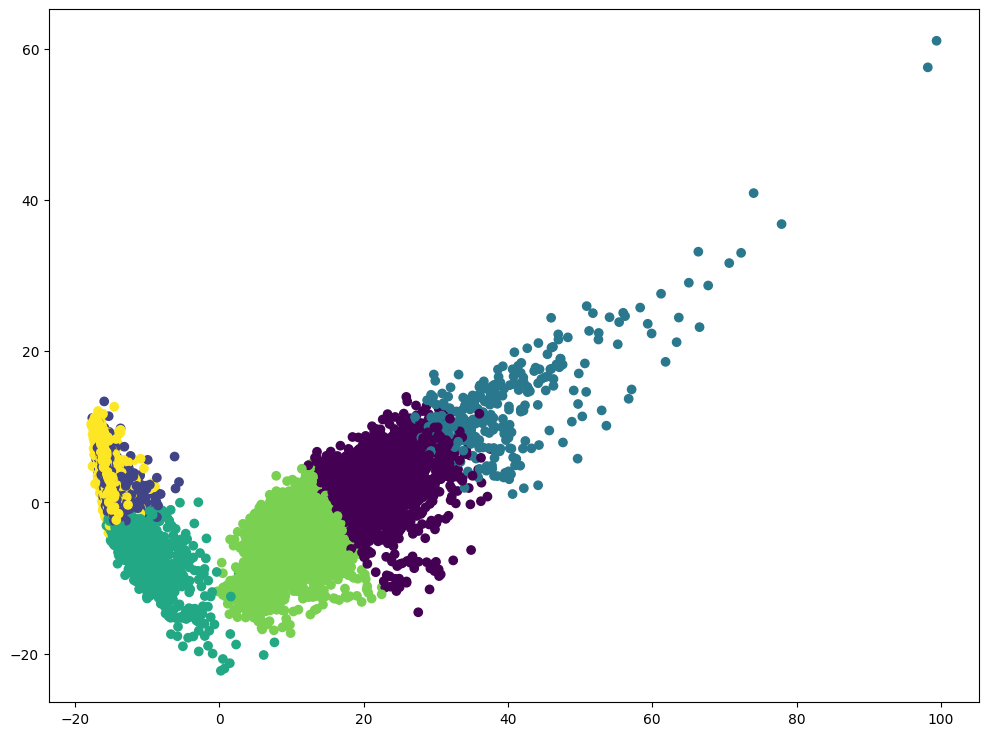

In [15]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=km.labels_, cmap='viridis') # ого как ровно всё стало

In [16]:
ypred = km.fit_predict(X_pca)

Выведите на экран значения метрик качества кластеризации

In [64]:
print(f'KM scores\nHomogeneity: {metrics.homogeneity_score(y, ypred)}\nCompleteness: {metrics.completeness_score(y, ypred)}\nAdjusted mutual info score: {metrics.adjusted_mutual_info_score(y, ypred)}\nV-measure: {metrics.v_measure_score(y, ypred)}\nAdjusted Rand-Index: {metrics.adjusted_rand_score(y, ypred)}\nSilhouette coefficient: {metrics.silhouette_score(X_pca, ypred, sample_size=1000)}')


KM scores
Homogeneity: 0.5407059871463014
Completeness: 0.581032341370277
Adjusted mutual info score: 0.5598338794580086
V-measure: 0.560144300533989
Adjusted Rand-Index: 0.41934612919061826
Silhouette coefficient: 0.11362086742330828


Теперь попробуем сделать кластеризацию с помощью AgglomerativeClustering (https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)

In [65]:
ag = AgglomerativeClustering(n_clusters=6, 
                             linkage='ward').fit(X_pca)

In [66]:
ag.fit(X_pca)
ypred = ag.fit_predict(X_pca)

Выведите метрики качества для полученного разбиения на кластеры. Сравните с kmeans. Запишите выводы!

In [67]:
print(f'AG scores\nHomogeneity: {metrics.homogeneity_score(y, ypred)}\nCompleteness: {metrics.completeness_score(y, ypred)}\nAdjusted mutual info score: {metrics.adjusted_mutual_info_score(y, ypred)}\nV-measure: {metrics.v_measure_score(y, ypred)}\nAdjusted Rand-Index: {metrics.adjusted_rand_score(y, ypred)}\nSilhouette coefficient: {metrics.silhouette_score(X_pca, ypred, sample_size=1000)}')

AG scores
Homogeneity: 0.566599811006291
Completeness: 0.612793880199985
Adjusted mutual info score: 0.5885009865465001
V-measure: 0.5887921892341146
Adjusted Rand-Index: 0.4407668305550883
Silhouette coefficient: 0.09630703522434175


### Вывод:
- все результаты немножко улучшились с AgglomerativeClustering, у KMeans чуть-чуть пониже.

Попробуйте применить другие методы кластеризации из sklearn. Также вычислите метрики качества и сделайте вывод о том, какой метод сработал лучше.

### Gaussian Mixture


In [75]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=6, covariance_type='tied')
ygm = gm.fit_predict(X_pca)

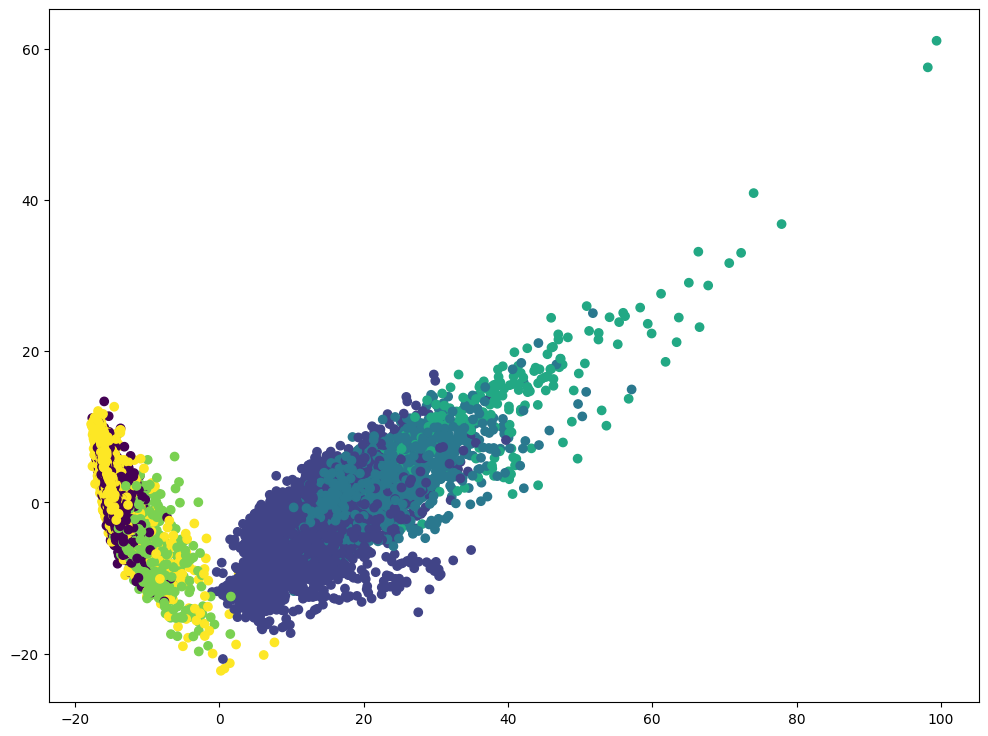

In [18]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=ygm, cmap='viridis')

In [20]:
print(f'Gaussian Mixture\nHomogeneity: {metrics.homogeneity_score(y, ygm)}\nCompleteness: {metrics.completeness_score(y, ygm)}\nAdjusted mutual info score: {metrics.adjusted_mutual_info_score(y, ygm)}\nV-measure: {metrics.v_measure_score(y, ygm)}\nAdjusted Rand-Index: {metrics.adjusted_rand_score(y, ygm)}\nSilhouette coefficient: {metrics.silhouette_score(X_pca, ygm, sample_size=1000)}')

Gaussian Mixture
Homogeneity: 0.648636953106225
Completeness: 0.7397710569713183
Adjusted mutual info score: 0.6909887539193506
V-measure: 0.6912130165011768
Adjusted Rand-Index: 0.569058440719022
Silhouette coefficient: 0.09249167875601445


Хороший результат!

In [21]:
# Gaussian Mixture spherical covariance
gm = GaussianMixture(n_components=6, covariance_type='spherical')
ygm = gm.fit_predict(X_pca)

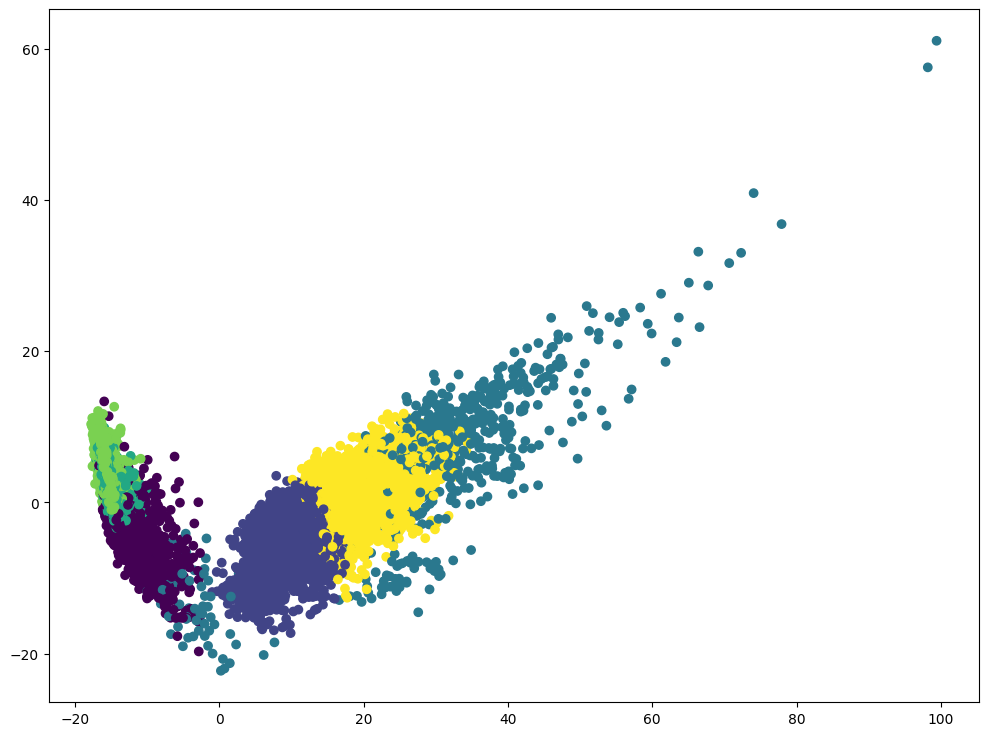

In [22]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=ygm, cmap='viridis')

In [23]:
print(f'Gaussian Mixture\nHomogeneity: {metrics.homogeneity_score(y, ygm)}\nCompleteness: {metrics.completeness_score(y, ygm)}\nAdjusted mutual info score: {metrics.adjusted_mutual_info_score(y, ygm)}\nV-measure: {metrics.v_measure_score(y, ygm)}\nAdjusted Rand-Index: {metrics.adjusted_rand_score(y, ygm)}\nSilhouette coefficient: {metrics.silhouette_score(X_pca, ygm, sample_size=1000)}')

Gaussian Mixture
Homogeneity: 0.5201392730156996
Completeness: 0.5382356786578106
Adjusted mutual info score: 0.528706593694521
V-measure: 0.5290327670085435
Adjusted Rand-Index: 0.3823260199465153
Silhouette coefficient: 0.08702792201857107


### DBSCAN

In [53]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=20, min_samples=3)
ydbscan = db.fit_predict(X_pca)

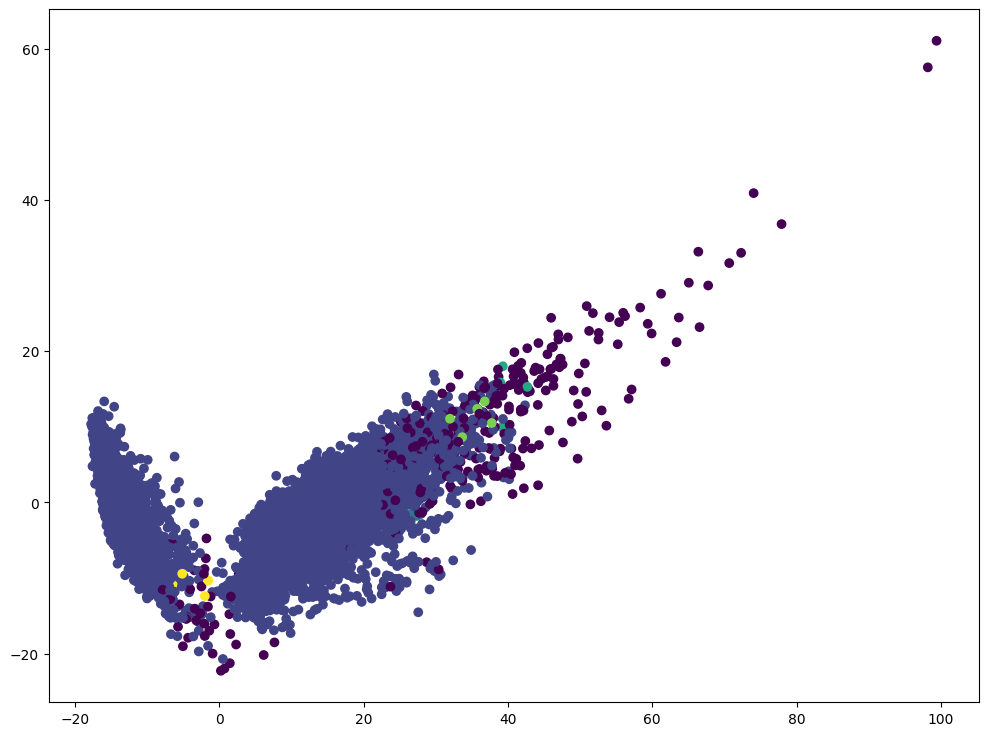

In [54]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=ydbscan, cmap='viridis')

In [55]:
print(f'DBSCAN\nHomogeneity: {metrics.homogeneity_score(y, ydbscan)}\nCompleteness: {metrics.completeness_score(y, ydbscan)}\nAdjusted mutual info score: {metrics.adjusted_mutual_info_score(y, ydbscan)}\nV-measure: {metrics.v_measure_score(y, ydbscan)}\nAdjusted Rand-Index: {metrics.adjusted_rand_score(y, ydbscan)}\nSilhouette coefficient: {metrics.silhouette_score(X_pca, ydbscan, sample_size=1000)}')

DBSCAN
Homogeneity: 0.017033817260731103
Completeness: 0.19851448345217956
Adjusted mutual info score: 0.030002834134111766
V-measure: 0.03137542187573661
Adjusted Rand-Index: 0.004864941109760197
Silhouette coefficient: 0.3447787418520102


Ну да, DBSCAN не очень подходит

### OPTICS

In [61]:
from sklearn.cluster import OPTICS

opt = OPTICS(max_eps=200)
y_opt = db.fit_predict(X_pca)

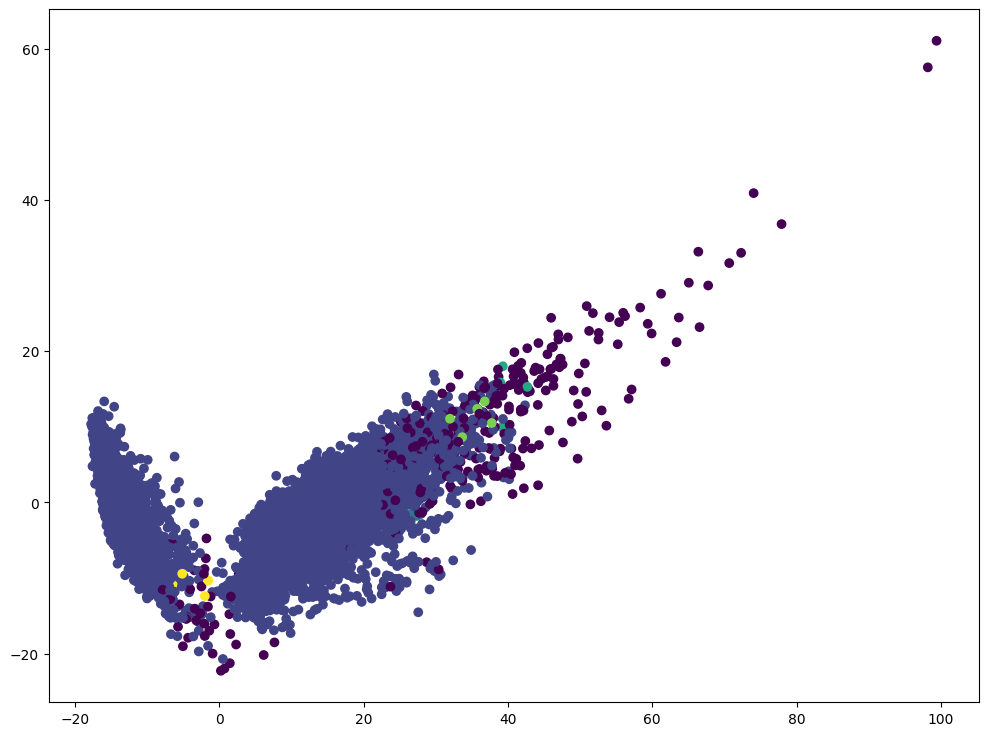

In [62]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_opt, cmap='viridis')

In [63]:
print(f'OPTICS\nHomogeneity: {metrics.homogeneity_score(y, y_opt)}\nCompleteness: {metrics.completeness_score(y, y_opt)}\nAdjusted mutual info score: {metrics.adjusted_mutual_info_score(y, y_opt)}\nV-measure: {metrics.v_measure_score(y, y_opt)}\nAdjusted Rand-Index: {metrics.adjusted_rand_score(y, y_opt)}\nSilhouette coefficient: {metrics.silhouette_score(X_pca, y_opt, sample_size=1000)}')

OPTICS
Homogeneity: 0.017033817260731103
Completeness: 0.19851448345217956
Adjusted mutual info score: 0.030002834134111766
V-measure: 0.03137542187573661
Adjusted Rand-Index: 0.004864941109760197
Silhouette coefficient: 0.32092312641381476


Для самой успешной из полученных кластеризаций попробуйте дать интерпретацию кластеров. Опишите характеристики объектов, попавших в каждый кластер. Для этого можете ответить на следующие вопросы:

* похожи ли объекты внутри каждого кластера на определенный тип активности человека?
* в каких кластерах смешано несколько типов активности? С чем, на ваш взгляд, это может быть связано?
* качественная ли получилась кластеризация? На основании чего вы можете сделать такой вывод?

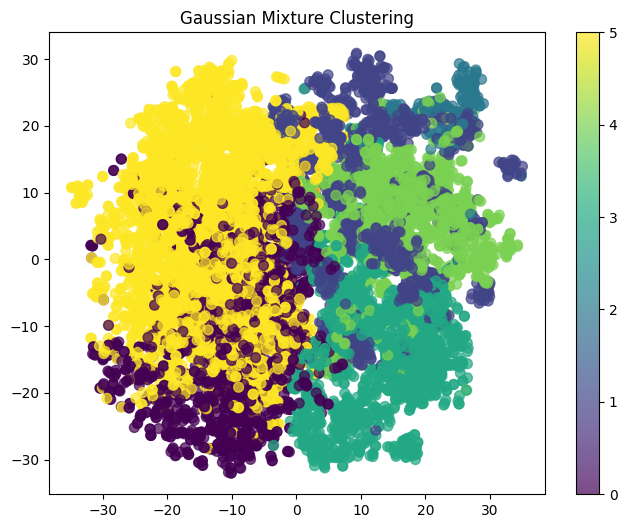

In [81]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, random_state=RANDOM_STATE)
tsneres = tsne.fit_transform(X_pca)

plt.figure(figsize=(8, 6))

# график
plt.scatter(tsneres[:, 0], tsneres[:, 1], c=ygm, cmap='viridis', s=50, alpha=0.7)
plt.colorbar()
plt.title('Gaussian Mixture Clustering')

plt.show()

# 1 - ходьбе, 2 - подъему вверх по лестнице, 3 - спуску по лестнице, 4 - сидению, 5 - стоянию, 6 - лежанию

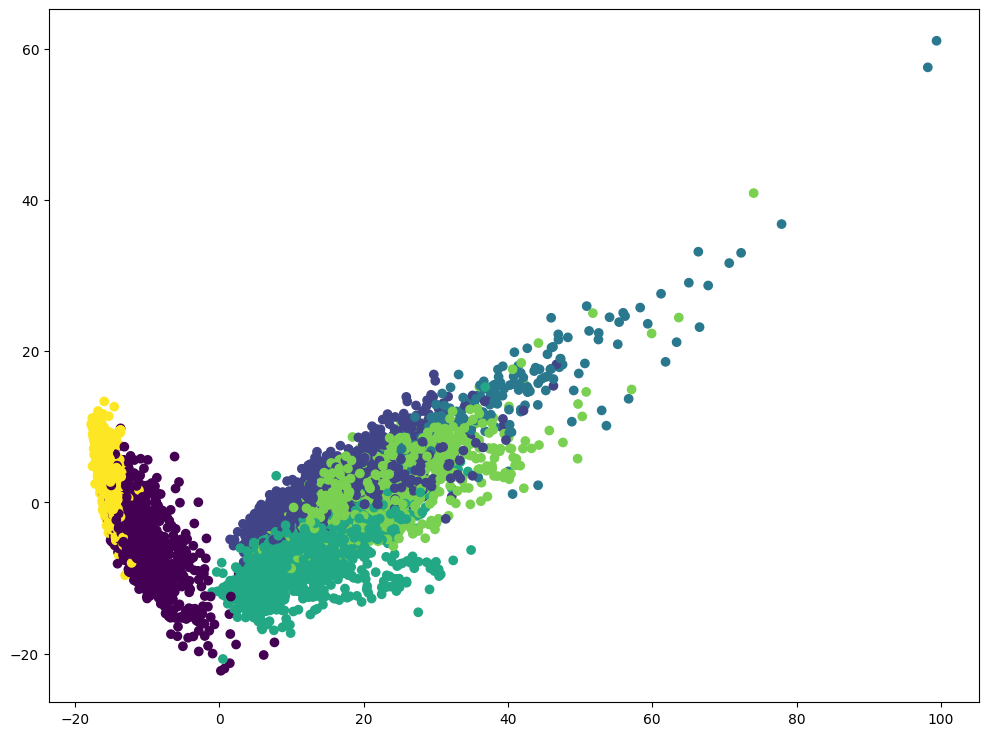

In [82]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=ygm, cmap='viridis')

1. Думаю, более-менее да.
2. Видно, что смешаны подъём и спуск по лестнице и ходьба. Предполагаю, что в принципе такое большое смешение связано с тем, что виды активности похожие, значит похожие значения всяких параметров (плюс ещё телефон был в кармане). Нет сильно различающихся активностей типа лежание/бег/прыжок с парашютом. Что интересно, кажется по графику, что сидение и лежание почти не смешиваются с другими кластерами (возможно, это как-то связано с гравитацией... или состоянием покоя).
3. Как будто да. Потому что при методе Gaussian Mixture лучше всего получились кластеры, и на графике кажется, что распределение приемлемое, у кластеров есть определённые очертания. 